In [1]:
import sys
import logging

so = open("data_lstm_2classes.log", 'w', 10)
sys.stdout.echo = so
sys.stderr.echo = so

get_ipython().log.handlers[0].stream = so
get_ipython().log.setLevel(logging.INFO)

In [1]:

from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyimpute import load_training_vector, load_targets, impute, evaluate_clf
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,SpatialDropout1D,GlobalMaxPooling1D,Input,Dropout,CuDNNLSTM,Conv1D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import re
import string
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pickle
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')
from numpy.random import permutation
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tqdm import tqdm

/home/alexandra_neagu/anaconda3/envs/gpu2/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alexandra_neagu/anaconda3/envs/gpu2/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# ###1.3 Set GPU Growth -> avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# #ia toate GPUs disponibile pe aceasta masina

# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu,True)
    
# tf.config.experimental.set_visible_devices(devices=gpus[1], device_type='GPU')
# tf.config.experimental.set_memory_growth(device=gpus[1], enable=True)

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
mental=pd.read_csv('../datasets/positive_reddit_combined.csv')
mental=mental.drop(['subreddit'],axis=1)
mental['subreddit']='mental'
nonmental=pd.read_csv('../datasets/negative_reddit_combined.csv')
full_data=pd.concat([nonmental,mental])
full_data=full_data.dropna(axis=0).reset_index(drop=True)
full_data

,Unnamed: 0,post,subreddit
0,0,neither obama hillary tweet new year greet tod...,nonmental
1,1,scott shane nation secure report new york time...,nonmental
2,2,list favorite people listen robert david steel...,nonmental
3,3,tumor user admit get vibrant gamepad get upvot...,nonmental
4,4,freeway crack system brilliant documentary exp...,nonmental
...,...,...,...
997393,362913,not make want live know ill never want im tota...,mental
997394,362914,fix hair go kill hair extreme mat month depr...,mental
997395,362915,harder swim faster sink feel like harder tri g...,mental
997396,362916,reason live im good place right im contempt su...,mental


In [ ]:
plt.figure(figsize=(8, 8))
colors = ["#ADBEDD","#903163"]
counts=full_data['subreddit'].value_counts().values.tolist()
plt.pie(counts, 
        labels = None,
        colors=colors,
        autopct=lambda x: '{:.0f}'.format(x*counts.sum()/100),
        textprops={'fontsize': 20})

plt.legend( ['Clasa Nonmental',"Clasa Mental"], loc='best', fontsize='large')

plt.show()

In [6]:
vocab_size=5000
max_length = 300
oov_tok = '<OOV>'
trunc_type = 'post'
padding_type = 'post'
embedding_dim = 128
MAX_SEQUENCE_LENGTH =300
MAX_NB_WORDS =1000
TRAIN_SIZE = 0.8

In [7]:
X=full_data["post"]
y=full_data["subreddit"].values

X_train, X_test, y_train, y_test = train_test_split (X,y,test_size=0.3, random_state=13, stratify=y )

X_train, X_validate, y_train, y_validate = train_test_split (X_train,y_train,train_size=0.8, random_state=18, stratify=y_train )

In [8]:
number_of_labels=full_data["subreddit"].nunique()

In [9]:
full_data["subreddit"].value_counts()

nonmental    634486
mental       362912
Name: subreddit, dtype: int64

tokenization


In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size=len(tokenizer.word_index) + 1
vocab_size

272111

In [11]:
import json
with open('word_index2.json', 'w') as f:
    json.dump(word_index, f)

In [12]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                             padding=padding_type, truncating=trunc_type)

In [13]:
train_padded[0]

array([  27,  389,  293,  221,   76,    8,  541,    6,   73, 1504, 1209,
        342, 3400,  275,    7,  564, 2520,   68,   10,   20, 1018,  257,
        212,   39,   60,  297,  108,  251,    5,   11,  506,  572, 3254,
          8, 2091,   26,   11, 1158,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [14]:
validation_sequences = tokenizer.texts_to_sequences(X_validate)
validation_padded = pad_sequences(validation_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)

In [15]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)

In [16]:
#transform label from text to number
encoder = LabelEncoder()
encoder.fit(y_train)

training_label_seq = encoder.transform(y_train)
test_label_seq = encoder.transform(y_test)
validation_label_seq = encoder.transform(y_validate)


In [17]:
reverse_word_index = dict(map(reversed, tokenizer.word_index.items()))

def decode_article(text):
     words = [reverse_word_index.get(letter) for letter in text]
     return(words)

Glove embeddings

In [18]:
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 50

In [19]:
words = {}
for example in X:
    for word in example.split():
        if word not in words:
            words[word] = 0
        else:
            words[word] += 1

In [20]:
# glove_embedding={}
embeddings_text = open('../datasets/glove.6B.300d.txt', 'r', encoding='utf-8')

In [21]:
# This will take some time
embeddings_index = {}

for line in embeddings_text:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
embeddings_text.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [22]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

callbacks

In [23]:
early_stop=EarlyStopping(patience=5, min_delta=0.01)
reducelr=ReduceLROnPlateau(patience=5)

Augumentare

In [24]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [25]:

def augumentation_synonym(row, augment_prob=0.3):
    decoded_row=decode_article(row)
    word_list = list(filter(None, decoded_row))
    num_words = len(word_list)
    string_row=decoded_row[0:num_words]
    sentence = " ".join(string_row)
    augSynonim=naw.SynonymAug(aug_p=augment_prob)
    aug_text=augSynonim.augment(sentence)
    aug_text_token=tokenizer.texts_to_sequences(aug_text)
    return aug_text

aug = nac.KeyboardAug()
def augumentation_char_keyboard(row):
    decoded_row=decode_article(row)
    word_list = list(filter(None, decoded_row))
    num_words = len(word_list)
    string_row=decoded_row[0:num_words]
    sentence = " ".join(string_row)
   
    augmented_text = aug.augment(sentence)
    return augmented_text


In [26]:
test_padded[0]

array([ 366,  178, 2111,  462,   64,  709,  826,  366,  178, 2111,  512,
         71,   72,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [27]:
augumentation_char_keyboard(test_padded[0])

'fight tax assess helpo any*ne sub suVsess fight tax assess purchase new home'

Generator

In [28]:
def generator(X_data,y_data,batch_size,ratio_aug=0,aug_function=None):
    cur_index=0
    max_index=X_data.shape[0]
    while True:
        rows=np.arange(cur_index,min(cur_index+batch_size,max_index))
        l=rows.size
        if aug_function is not None:
            aug_rows=np.random.choice(rows,int(l*ratio_aug),replace=False)
            orig_rows=np.setdiff1d(rows,aug_rows)
            
            aug_samples=np.array([aug_function(X_data[i]) for i in aug_rows])
            aug_samples = np.reshape(aug_samples, (len(aug_samples), 1))
            df = pd.DataFrame(aug_samples,columns=['col'])
            aug_samples_token = tokenizer.texts_to_sequences(df['col'])

            aug_samples_padd = pad_sequences(aug_samples_token, maxlen=MAX_SEQUENCE_LENGTH, padding=padding_type, truncating=trunc_type)
            orig_samples=X_data[orig_rows]
            
            samples=np.concatenate((aug_samples_padd,orig_samples),axis=0)
            targets=np.concatenate((y_data[aug_rows],y_data[orig_rows]),axis=0)
        else:
            samples=X_data[rows]
            targets=y_data[rows]
        cur_index+=len(rows)
        if(cur_index>=max_index):
            cur_index=0
        yield samples, targets

In [29]:
# training_label_seq=training_label_seq.reshape(-1,1)
# validation_label_seq=validation_label_seq.reshape(-1,1)

In [30]:
train_gen=generator(train_padded,training_label_seq,BATCH_SIZE)
val_gen=generator(validation_padded,validation_label_seq,BATCH_SIZE)


In [31]:
train_len=train_padded.shape[0]
val_len=validation_padded.shape[0]
num_epochs =50
val_steps=val_len/BATCH_SIZE
train_steps=train_len/BATCH_SIZE

print(train_steps, val_steps)

17454.4375 4363.625


Cream model

In [32]:
labels=np.unique(training_label_seq,return_counts=True)
labels

(array([0, 1]), array([203230, 355312]))

In [33]:
class_weights={}
total=labels[1].sum()
num_classes=2
print(total)
for i in labels[0]:
    class_weights[i]=total/(num_classes*labels[1][i])
class_weights

558542


{0: 1.3741622791910644, 1: 0.7859880893411987}

In [34]:
def class_weight_compute(labels_dict,mu=0.15):
    print(labels_dict)
    total = np.sum(labels_dict[1])
    keys = labels_dict[0]
    weight = dict()
    for i in keys:
        score = np.log(mu*total/float(labels_dict[1][i]))
        print(i,score)
        weight[i] = score if score > 1 else 1
    return weight
# random labels_dict
labels_dict =np.unique(training_label_seq,return_counts=True)
weights = class_weight_compute(labels_dict)
weights

(array([0, 1]), array([203230, 355312]))
0 -0.8861285103739193
1 -1.4447864445036074


{0: 1, 1: 1}

In [35]:
model1 = Sequential([
    Input(shape=MAX_SEQUENCE_LENGTH),
    Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
              trainable=False,input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(64,dropout=0.2,return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32,activation='relu'),
    Dropout(0.3),
    Dense(number_of_labels, activation='sigmoid')
])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          81633300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 128)          186880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

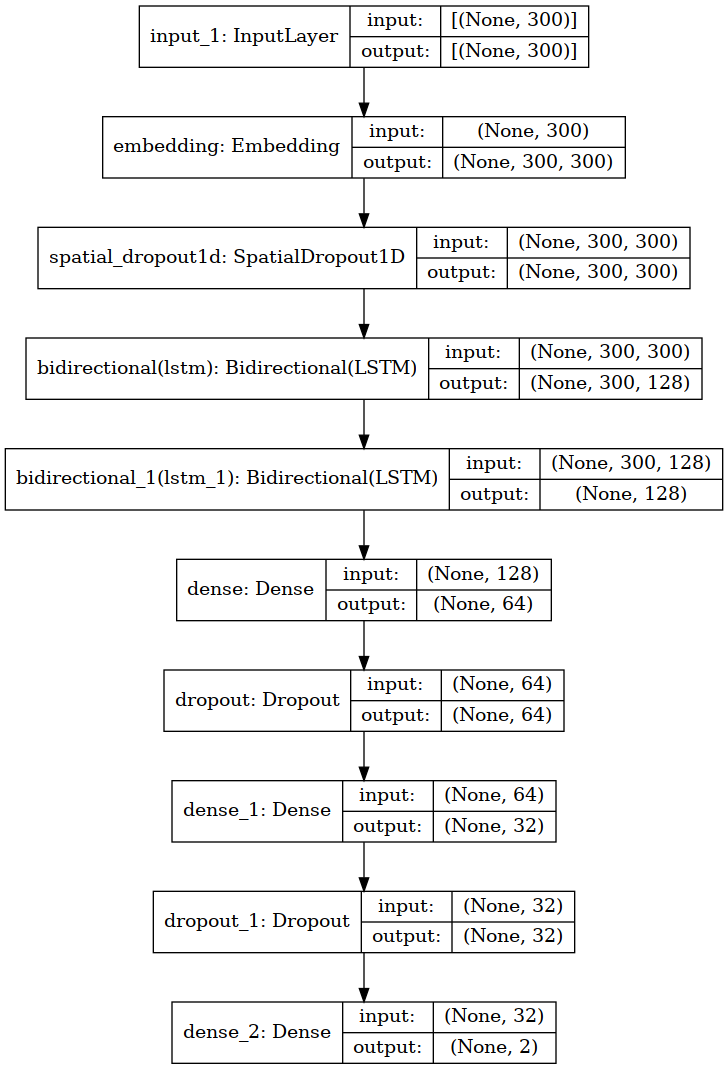

In [36]:

tf.keras.utils.plot_model(model1, to_file='./2classimg.png', show_shapes=True)

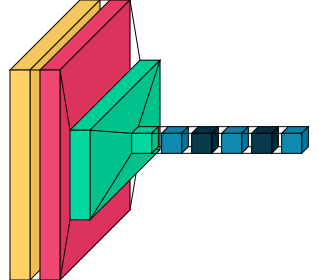

In [37]:
import visualkeras
visualkeras.layered_view(model1,scale_xy=0.7)


In [38]:
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              metrics=['accuracy'])

history1 = model1.fit( 
    train_gen,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=[early_stop,reducelr],verbose=1)

Epoch 1/50
17454/17454 [==============================] - 4198s 240ms/step - loss: 0.1731 - accuracy: 0.9341 - val_loss: 0.1205 - val_accuracy: 0.9543
Epoch 2/50
17454/17454 [==============================] - 4182s 240ms/step - loss: 0.1261 - accuracy: 0.9538 - val_loss: 0.1138 - val_accuracy: 0.9570
Epoch 3/50
17454/17454 [==============================] - 4185s 240ms/step - loss: 0.1148 - accuracy: 0.9580 - val_loss: 0.1080 - val_accuracy: 0.9596
Epoch 4/50
17454/17454 [==============================] - 4194s 240ms/step - loss: 0.1082 - accuracy: 0.9605 - val_loss: 0.1081 - val_accuracy: 0.9596
Epoch 5/50
17454/17454 [==============================] - 4191s 240ms/step - loss: 0.1040 - accuracy: 0.9616 - val_loss: 0.1085 - val_accuracy: 0.9606
Epoch 6/50
17454/17454 [==============================] - 4184s 240ms/step - loss: 0.1006 - accuracy: 0.9630 - val_loss: 0.1087 - val_accuracy: 0.9617
Epoch 7/50
17454/17454 [==============================] - 4185s 240ms/step - loss: 0.0978 - ac

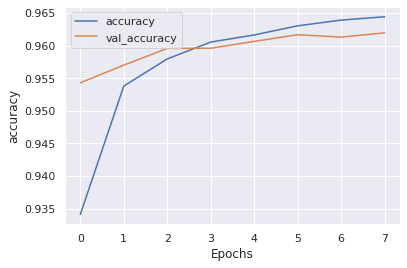

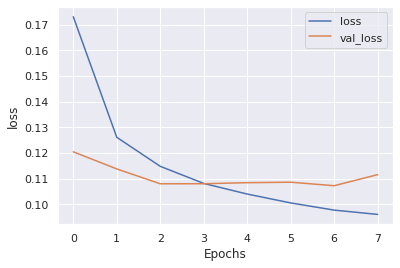

In [39]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

In [40]:
model1.save('./model_lstm_2classes_aftercorrect')

INFO:tensorflow:Assets written to: ./model_lstm_2classes_aftercorrect/assets


INFO:tensorflow:Assets written to: ./model_lstm_2classes_aftercorrect/assets


In [41]:
# Make predictions on the test data
y_pred = model1.predict(test_padded)


In [42]:
from sklearn.metrics import classification_report

# Convert predictions to labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels
y_true_labels =test_label_seq

test_label_text = encoder.inverse_transform(y_true_labels)
pred_label_text = encoder.inverse_transform(y_pred_labels)

# Print the classification report
print(classification_report(test_label_text, pred_label_text))

              precision    recall  f1-score   support

      mental       0.94      0.96      0.95    108874
   nonmental       0.98      0.96      0.97    190346

    accuracy                           0.96    299220
   macro avg       0.96      0.96      0.96    299220
weighted avg       0.96      0.96      0.96    299220



<AxesSubplot:>

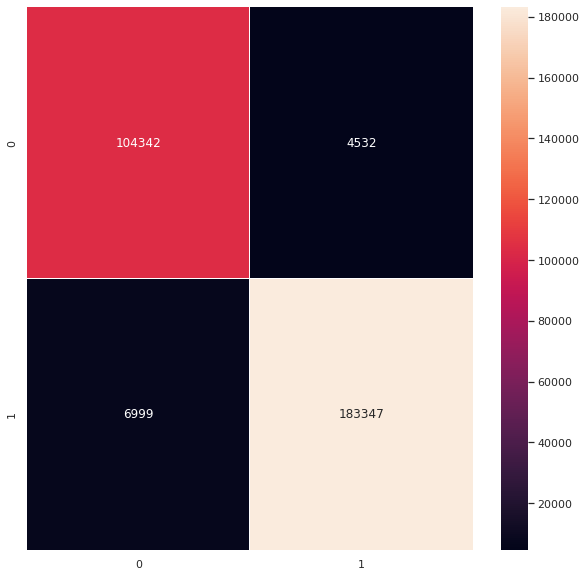

In [43]:
cm=confusion_matrix(test_label_text,pred_label_text)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(cm, annot=True, linewidths = 0.01,ax=ax, fmt='g')

In [44]:
tf.keras.models.save_model(model1, "model_2classes.h5")

In [45]:
# model = tf.keras.models.load_model('../model_lstm_2classes_aftercorrect')